# Titanic Survival Predictor 🚢

This project analyzes passenger data from the Titanic disaster and builds machine learning models to predict survival.

## Objective
To predict whether a passenger survived based on features like:
- Age
- Gender
- Passenger Class
- Fare
- Family Relationships

This is a binary classification problem:
- 0 → Did Not Survive
- 1 → Survived

In [6]:
# ===============================
# TITANIC SURVIVAL PREDICTOR
# ===============================

# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Model Saving
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv("../data/train.csv")

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
df.info()

df.describe()

df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

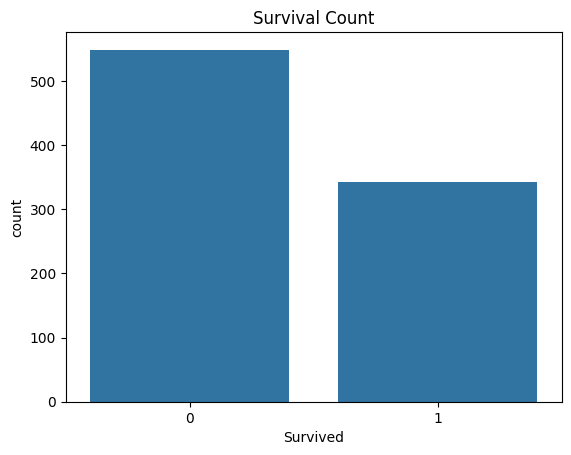

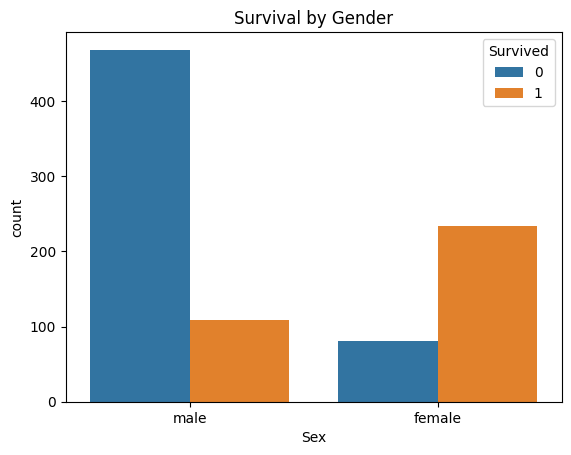

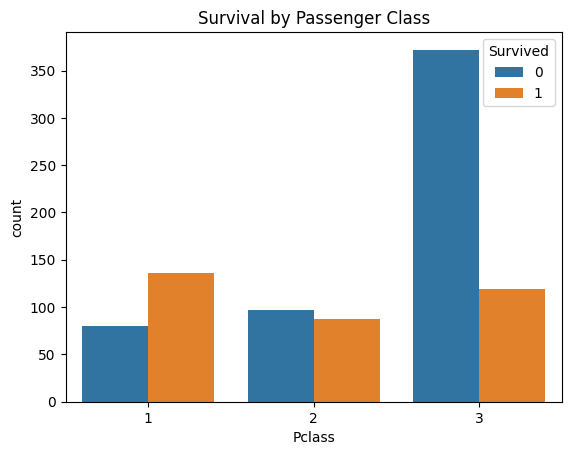

In [9]:
sns.countplot(x="Survived", data=df)
plt.title("Survival Count")
plt.show()

sns.countplot(x="Sex", hue="Survived", data=df)
plt.title("Survival by Gender")
plt.show()

sns.countplot(x="Pclass", hue="Survived", data=df)
plt.title("Survival by Passenger Class")
plt.show()

In [10]:
# Fill Age with median grouped by Pclass
df["Age"] = df.groupby("Pclass")["Age"].transform(lambda x: x.fillna(x.median()))

# Fill Embarked with mode
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

# Drop Cabin
df.drop(columns=["Cabin"], inplace=True)

df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [11]:
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

df["Title"] = df["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)

rare_titles = ["Lady","Countess","Capt","Col","Don","Dr","Major","Rev","Sir","Jonkheer","Dona"]
df["Title"] = df["Title"].replace(rare_titles, "Rare")
df["Title"] = df["Title"].replace(["Mlle","Ms"], "Miss")
df["Title"] = df["Title"].replace("Mme", "Mrs")

In [12]:
le = LabelEncoder()
df["Sex"] = le.fit_transform(df["Sex"])

df = pd.get_dummies(df, columns=["Embarked","Title"], drop_first=True)

In [13]:
df.drop(columns=["PassengerId","Name","Ticket"], inplace=True)

In [14]:
scaler = StandardScaler()
df[["Age","Fare","FamilySize"]] = scaler.fit_transform(df[["Age","Fare","FamilySize"]])

In [15]:
X = df.drop("Survived", axis=1)
model_columns = X.columns
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [16]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(name, "Accuracy:", accuracy_score(y_test, preds))

Logistic Regression Accuracy: 0.7988826815642458
Decision Tree Accuracy: 0.7541899441340782
Random Forest Accuracy: 0.8324022346368715
SVM Accuracy: 0.8268156424581006


In [17]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = accuracy_score(y_test, preds)

comparison_df = pd.DataFrame(results.items(), columns=["Model", "Accuracy"])
comparison_df.sort_values(by="Accuracy", ascending=False)

,Model,Accuracy
2,Random Forest,0.832402
3,SVM,0.826816
0,Logistic Regression,0.798883
1,Decision Tree,0.754190


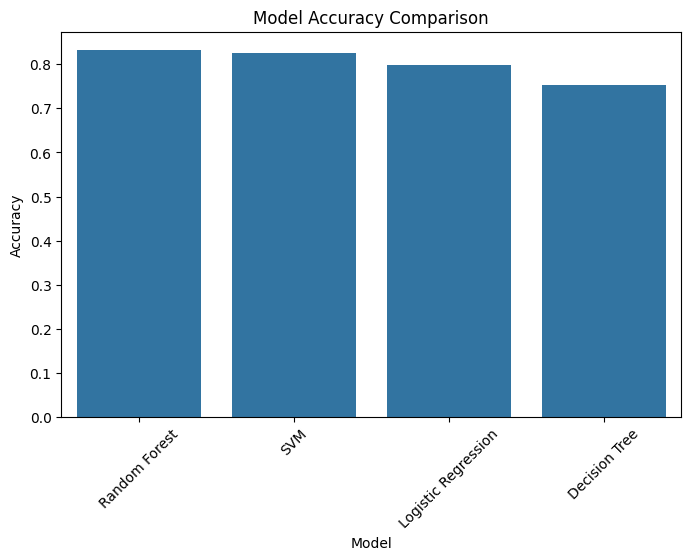

In [18]:
comparison_df = comparison_df.sort_values(by="Accuracy", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Accuracy", data=comparison_df)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()

In [19]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid,
                    cv=5,
                    scoring="accuracy")

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("Best Parameters:", grid.best_params_)

Best Parameters: {'max_depth': 5, 'n_estimators': 200}


In [ ]:
final_preds = best_model.predict(X_test)

print("Final Accuracy:", accuracy_score(y_test, final_preds))
print(classification_report(y_test, final_preds))

Final Accuracy: 0.8268156424581006
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(y_test, final_preds))
print("Recall:", recall_score(y_test, final_preds))
print("F1 Score:", f1_score(y_test, final_preds))

Precision: 0.8115942028985508
Recall: 0.7567567567567568
F1 Score: 0.7832167832167832


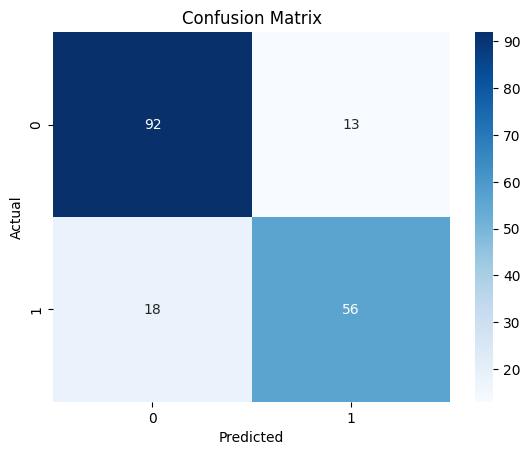

In [33]:
cm = confusion_matrix(y_test, final_preds)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

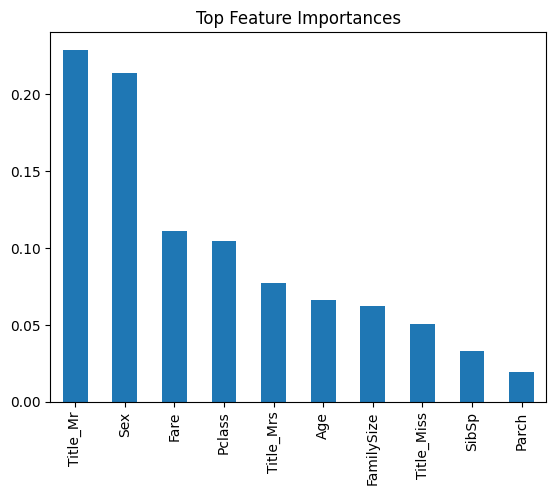

In [22]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Top Feature Importances")
plt.show()

In [23]:
model_package = {
    "model": best_model,
    "label_encoder": le,
    "scaler": scaler,
    "model_columns": model_columns
}

with open("titanic_model.pkl", "wb") as f:
    pickle.dump(model_package, f)

print("Model Package Saved Successfully!")

Model Package Saved Successfully!


In [24]:
def predict_survival(age, sex, pclass, fare, sibsp, parch, embarked="S", title="Mr"):
    
    # Create base dataframe with all training columns initialized to 0
    input_data = pd.DataFrame(columns=model_columns)
    input_data.loc[0] = 0
    
    # Basic numeric features
    input_data["Pclass"] = pclass
    input_data["Sex"] = le.transform([sex])[0]
    input_data["Age"] = age
    input_data["SibSp"] = sibsp
    input_data["Parch"] = parch
    input_data["Fare"] = fare
    input_data["FamilySize"] = sibsp + parch + 1
    
    # One-hot encoded features
    if f"Embarked_{embarked}" in input_data.columns:
        input_data[f"Embarked_{embarked}"] = 1
        
    if f"Title_{title}" in input_data.columns:
        input_data[f"Title_{title}"] = 1

    if age < 0 or fare < 0:
        return "Invalid input: Age and Fare must be positive."
    
    if sex not in ["male", "female"]:
        return "Invalid input: Sex must be 'male' or 'female'."    
    
    # Scale numeric features
    input_data[["Age","Fare","FamilySize"]] = scaler.transform(
        input_data[["Age","Fare","FamilySize"]]
    )
    
    prediction = best_model.predict(input_data)
    
    return "Survived" if prediction[0] == 1 else "Did Not Survive"

In [25]:
predict_survival(
    age=25,
    sex="female",
    pclass=1,
    fare=100,
    sibsp=0,
    parch=0,
    embarked="C",
    title="Miss"
)

'Survived'

In [26]:
print(best_model)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)
